# Question 1

The CIFAR-10 and CIFAR-100 datasets are benchmarks for image classification tasks in
computer vision. In this exercise, you will explore how different neural network architectures
perform on these image datasets.

Tasks
1. Multilayer Perceptron (MLP):
○ Develop a Multilayer Perceptron (MLP) model with an appropriate architecture (number
of layers, hidden units, etc.).
○ Train the MLP model on the CIFAR-10 dataset.
○ Evaluate its performance on the test set using metrics like accuracy and loss. Analyze
the results.
2. Convolutional Neural Network (CNN):
○ Design a simple Convolutional Neural Network (CNN) architecture with convolutional
layers, pooling layers, and fully connected layers.
○ Train the CNN model on the CIFAR-10 dataset.
○ Evaluate its performance on the test set using the same metrics as the MLP. Critically
compare CNN's performance to the MLP's.
3. Transfer Learning with VGG:
○ Utilize a pre-trained VGG model (such as VGG16 or VGG19) available in common deep
learning libraries.
○ Adapt the pre-trained VGG model for the CIFAR-10 or CIFAR-100 classification task.
○ Evaluate its performance on the test set. Analyze the benefits of transfer learning
compared to your MLP and CNN models trained from scratch.
Analysis and Discussion

- Compare the test set accuracy and loss across the MLP, CNN, and the VGG-based model.
- Discuss the reasons behind the differences in performance. Explain how CNNs leverage the
spatial structure of images for better feature extraction compared to MLPs.
- If you used the VGG model, elaborate on how transfer learning helped improve performance
or reduce training time.


Tips (Not Graded):
- Data Preprocessing: Consider normalizing the data and employing data augmentation
techniques if needed.https://anushsom.medium.com/image-augmentation-for-creating-datasets-using-pytorch-for-dummies-by-a-dummy-a7c2b08c5bcb#:~:text=Gaussian%20Noise,gaussian%20noise%20function%20in%20torchvision.
- Hyperparameter Tuning: Experiment with different learning rates, optimizers, and network
architectures to fine-tune your models.
- Visualization: Visualize the filters learned by the CNN to gain insights into what features are
being detected

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F

In [2]:
print(torch.cuda.device_count())

1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### data Handling

In [4]:
transform_train = transforms.Compose( [ 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                # transforms.RandomHorizontalFlip(),  
                                # transforms.RandomRotation(10),
                                # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
                                # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
                                # transforms.RandomCrop(32, padding=4)
                                ])

transform_test = transforms.Compose( [ 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#datasets loading
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)



#dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(trainset.data.shape)
print(testset.data.shape)
print(trainset.data[0].shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(32, 32, 3)


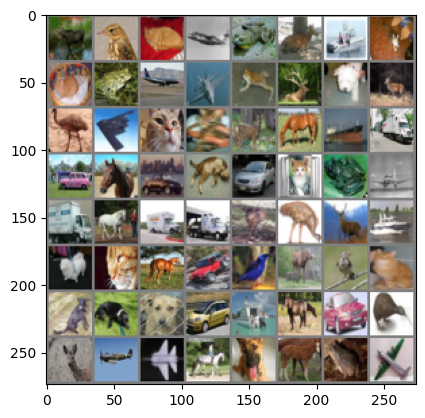

In [6]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

### 1. MLP


In [7]:
configurations = {
    'lr' : 0.001,
    'epochs' : 5,
    'input_size' : 32*32*3,
    'hidden_size1' : 256,
    'hidden_size2' : 128,
    'hidden_size3' : 64,
    'classes' : 10

}

In [8]:
#class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# model creation
model = MLP(configurations['input_size'], configurations['hidden_size1'], configurations['hidden_size2'], configurations['hidden_size3'], configurations['classes']).to(device)

In [9]:
# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=configurations['lr'])  


for epoch in range(configurations['epochs']):
    for i, (img, obj_class) in enumerate(trainloader):
        # print(img.shape)
        img = img.reshape(-1, 32*32*3).to(device)
        # print(img.shape)
        obj_class = obj_class.to(device)

        # Forward pass
        predictions = model(img)
        loss = criterion(predictions, obj_class)

        # Backpropogation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'epoch: {epoch+1}  loss: {loss.item()}')

epoch: 1  loss: 1.7975646257400513
epoch: 2  loss: 1.945088505744934
epoch: 3  loss: 1.2417542934417725
epoch: 4  loss: 1.8112950325012207
epoch: 5  loss: 2.1086695194244385


In [10]:
#testing
model.eval()

with torch.no_grad():
    correct = 0
    for i, (img, obj_class) in enumerate(testloader):
        img = img.reshape(-1, 32*32*3).to(device)
        obj_class = obj_class.to(device)

        predictions = model(img)
        img, op = torch.max(predictions, 1)
        correct = correct + (op == obj_class).sum().item()
    
    print(f'Test Accuracy: {(correct/len(testloader.dataset)) *100}%')

Test Accuracy: 50.12%


### CNN


In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x))   # 32, 30, 30
        x = self.pool(x)            # 32, 15, 15
        x = F.relu(self.conv2(x))   # 64, 13, 13
        x = self.pool(x)            # 64, 6, 6
        x = F.relu(self.conv3(x))   # 64, 4, 4
        x = torch.flatten(x, 1)     # 1024
        x = F.relu(self.fc1(x))     # 64
        x = self.fc2(x)             # 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=configurations['lr'])

n_total_steps = len(trainloader)
for epoch in range(configurations['epochs']):

    running_loss = 0.0

    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

[1] loss: 1.516
[2] loss: 1.182
[3] loss: 1.023
[4] loss: 0.910
[5] loss: 0.822


In [12]:
model.eval()

with torch.no_grad():
    correct = 0
    total = len(testloader.dataset)

    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f'Accuracy of the model: {acc*100} %')


Accuracy of the model: 69.08999999999999 %


### Transfer learning


In [13]:
import torchvision.models as models
from torch.utils.data import Subset

In [14]:
transform_custom = transforms.Compose( [ 
                                transforms.Resize((224, 224)), # adding as original VGG model has large input size our is very small
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

batch_size = 64

#datasets loading
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_custom)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_custom)
# trainset = Subset(trainset, range(10000))

#dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
model_vgg16 = models.vgg16(pretrained=True) #loading VGG16
for param in model_vgg16.parameters():      #freezing
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model_vgg16.classifier[3] = nn.Linear(in_features=4096, out_features=256)
model_vgg16.classifier[6] = nn.Linear(in_features=256, out_features=10) 

for param in model_vgg16.classifier[3].parameters():
    param.requires_grad = True

for param in model_vgg16.classifier[6].parameters():
    param.requires_grad = True
model_vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=configurations['lr'])

n_total_steps = len(trainloader)
for epoch in range(configurations['epochs']):

    running_loss = 0.0

    for i, (images, labels) in enumerate(trainloader):
#         print(i, end=' ')
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

[1] loss: 0.783
[2] loss: 0.665
[3] loss: 0.625
[4] loss: 0.606
[5] loss: 0.597


In [18]:
for name, param in model_vgg16.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
classifier.0.weight False
classifier.0.bias False
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [19]:
model_vgg16.eval()

with torch.no_grad():
    correct = 0
    total = len(testloader.dataset)

    for i, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        print(i, end=' ')

    acc = correct / total
    print(f'Accuracy of the model: {acc*100} %')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 Accuracy of the model: 82.96 %


### Compare the test set accuracy and loss across the MLP, CNN, and the VGG-based model.


#### test set accuracy
1. MLP: 50.12%

2. CNN: 69.08999999999999%

3. VGG-based model: 82.96%


### Discuss the reasons behind the differences in performance. Explain how CNNs leverage the spatial structure of images for better feature extraction compared to MLPs.


#### reasons behind the differences in performance
1. Spatial Structure Utilization: CNNs are designed to leverage the spatial structure of images through convolutional layers, making them to extract hierarchical features effectively, unlike MLPs which treat input data as flat vectors.

2. Parameter Efficiency: Due to shared weights in convolutional filters, CNNs require fewer parameters compared to MLPs, making them more efficient and less prone to overfitting when dealing with high-dimensional image data.

3. Translation Invariance: CNNs, through pooling layers, achieve translation invariance, allowing them to detect features regardless of their position in the image. MLPs lack this capability, making them less effective for image recognition tasks.

4. Feature Extraction: CNNs automatically learn and extract relevant features from images during training, a process that is more direct and efficient compared to the manual feature engineering often required for MLPs to perform similarly well on image tasks.

5. Transfer Learning Efficiency: Utilizing transfer learning with models like VGG allows leveraging pre-trained, optimized feature extractors, significantly improving performance and reducing training time by reusing learned features adaptable to new but related tasks.

#### CNNs leverage the spatial structure of images for better feature extraction compared to MLPs because,

CNNs automatically learn to extract features from spatial structure of images during training, identifying the most relevant features for the task at hand. In contrast, MLPs do not have mechanisms to extract structured features from images efficiently, often requiring manual feature engineering to achieve comparable results.

### If you used the VGG model, elaborate on how transfer learning helped improve performance or reduce training time

1. Leveraged Pre-trained Features: VGG, pre-trained on a large dataset like ImageNet, comes with a rich set of feature detectors that are broadly applicable across a wide range of image recognition tasks, our images closly realted to Imagenet so will work fine in this case

2. Reduced Need for Feature Discovery: Since VGG already understands fundamental image features (edges, textures, etc.), the model can skip the initial, often time-consuming phase of learning these from scratch, directly applying these pre-learned features to the new task.

3. Focus on Higher-level Feature Refinement: Transfer learning allows the model to focus training efforts on adjusting higher-level features and the classifier to the specific task at hand, rather than developing feature detectors from the ground up.

4. Rapid Convergence: By starting with weights that are already optimized for similar tasks, models utilizing transfer learning with VGG can converge faster to effective solutions, significantly reducing training time.

5. Enhanced Model Performance on Smaller Datasets: VGG's pre-trained layers can act as a powerful feature extractor for the new task, enabling the model to perform well even on smaller datasets like in our case.